In [85]:
# First try to use the data to train a model
import numpy as np
import random
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.client import device_lib
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, TimeDistributed, Bidirectional, BatchNormalization
from keras import regularizers
from keras.optimizers import SGD
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import math
import csv
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn import model_selection

print(tf.config.experimental.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [86]:
# Load the dataset from the file
SensorValues = pd.read_csv('mySensorData.csv', header = None)
LocationValues = pd.read_csv('myLocationData.csv', header = None)
# SortedVal = pd.read_csv('mySortedVal.csv', header = None)
# SortedTest = pd.read_csv('mySortedTest.csv', header = None)

SensorValues.head()
LocationValues.head()
# SortedValues.head()

sensor_arr = SensorValues.values
location_arr = LocationValues.values
# sorted_val= SortedVal.values
# sorted_test= SortedTest.values

print(sensor_arr.shape)
print(location_arr.shape)
# print(sorted_val.shape)
# print(sorted_test.shape)

print(np.min(sensor_arr))
print(np.max(sensor_arr))


In [ ]:
def min_max_scaler(data):
    # Calculate the minimum and maximum values of the data
    
    min_val = np.min(data)
    max_val = np.max(data)
    
    scaled_data = (data - min_val) / (max_val - min_val)
    
    return scaled_data

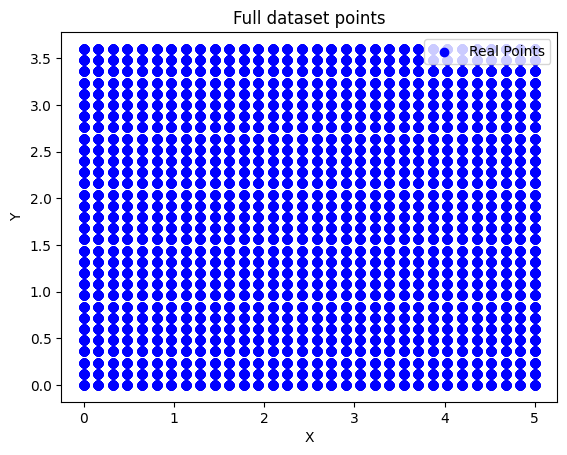

In [ ]:
# Preview the Location of the real data points

plt.scatter(location_arr[:,0], location_arr[:,1], color='blue', label='Real Points')

# # Set the x-axis label to "X"
plt.xlabel('X')

# # Set the y-axis label to "Y"
plt.ylabel('Y')

# # Set the title of the plot to "Real vs Predicted Points"
plt.title('Full dataset points')

# # Add a legend to the plot
plt.legend()

# Show the plot
plt.show()
        


In [ ]:
train_size_per = 0.7    # 70% of the data is used for training
                        # 15% of the data is used for validation
                        # 15% of the data is used for testing
rotation_per_position = 8

reads_per_position = 10    

total_values_per_position = rotation_per_position * reads_per_position              


X = min_max_scaler(sensor_arr)
Y_loc_0 = min_max_scaler(location_arr[:,0])
Y_loc_1 = min_max_scaler(location_arr[:,1])
Y_rot = min_max_scaler(location_arr[:,2])

Y = np.zeros((Y_loc_0.shape[0], 3))

for i in range(0, Y_loc_0.shape[0]):
    Y[i,0] = Y_loc_0[i]
    Y[i,1] = Y_loc_1[i]
    Y[i,2] = Y_rot[i]


data_sen_size = int(X.shape[0])
data_sen_size_2 = int(X.shape[1])

data_loc_size = int(Y.shape[0])
data_loc_size_2 = int(Y.shape[1])



val_size = int(data_sen_size * (1 - train_size_per)*2/3)
test_size = int(data_sen_size * (1 - train_size_per)*1/3)
train_size = int(data_sen_size * train_size_per)



In [ ]:
data_size_rotation = int(data_sen_size / total_values_per_position)

val_test_size_per = int(data_size_rotation * (1 - train_size_per))

random_numbers = random.sample(range(0, data_size_rotation), val_test_size_per)

random.shuffle(random_numbers)

halfway = len (random_numbers) // 3

test_random = random_numbers[:halfway]
val_random = random_numbers[halfway:3*halfway]

val_numbers = np.zeros((val_size, 1))
test_numbers = np.zeros((test_size, 1))

n_val = 0
for i in val_random:
    for j in range(0, total_values_per_position):
        val_numbers[n_val] = i * total_values_per_position + j
        n_val = n_val + 1

n_test = 0
for i in test_random:
    for j in range(0, total_values_per_position):
        test_numbers[n_test] = i * total_values_per_position + j
        n_test = n_test + 1
        
val_sorted = np.sort(val_numbers, axis=0)
test_sorted = np.sort(test_numbers, axis=0)

In [ ]:
# with open('mySortedVal.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     for row in val_sorted:
#         writer.writerow(row)
     
# with open('mySortedTest.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     for row in test_sorted:
#         writer.writerow(row)   

# SortedVal = pd.read_csv('mySortedVal.csv', header = None)
# SortedTest = pd.read_csv('mySortedTest.csv', header = None)

# val_sorted= SortedVal.values
# test_sorted= SortedTest.values

In [ ]:
X_train = np.zeros((train_size, data_sen_size_2))
Y_train = np.zeros((train_size, data_loc_size_2))

X_val = np.zeros((val_size, data_sen_size_2))
Y_val = np.zeros((val_size, data_loc_size_2))

X_test = np.zeros((test_size, data_sen_size_2))
Y_test = np.zeros((test_size, data_loc_size_2))

n_test = 0
n_train = 0
n_val = 0

for i in range (0, data_sen_size):
    if i in val_sorted:
        X_val[n_val] = X[i]
        Y_val[n_val] = Y[i]
        n_val = n_val + 1
    elif i in test_sorted:
        X_test[n_test] = X[i]
        Y_test[n_test] = Y[i]
        n_test = n_test + 1
    else:
        X_train[n_train] = X[i]
        Y_train[n_train] = Y[i]
        n_train = n_train + 1

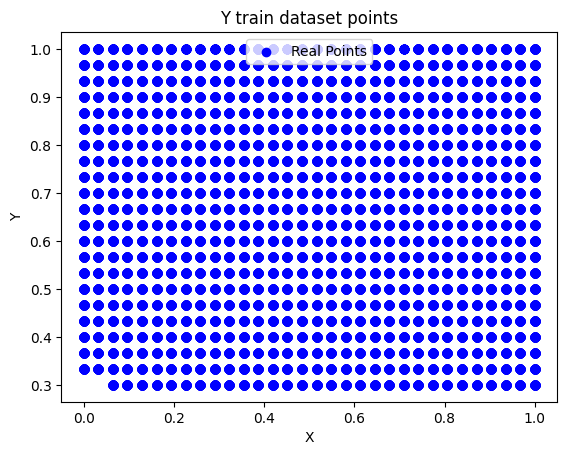

In [ ]:
# Split the data into training and testing sets
plt.scatter(Y_train[:,0], Y_train[:,1], color='blue', label='Real Points')

# # Set the x-axis label to "X"
plt.xlabel('X')

# # Set the y-axis label to "Y"
plt.ylabel('Y')

# # Set the title of the plot to "Real vs Predicted Points"
plt.title('Y train dataset points')

# # Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

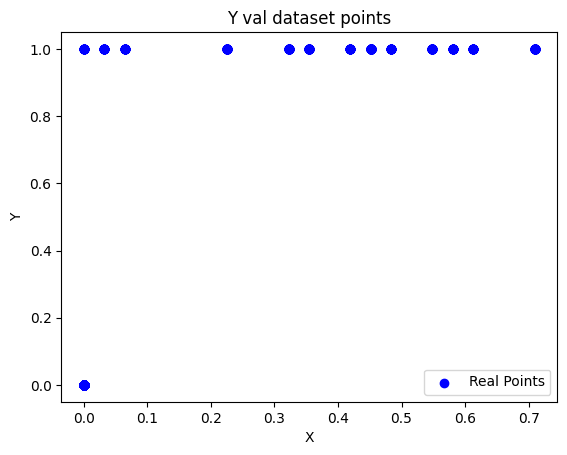

In [ ]:
plt.scatter(Y_val[:,0], Y_val[:,1], color='blue', label='Real Points')

# # Set the x-axis label to "X"
plt.xlabel('X')

# # Set the y-axis label to "Y"
plt.ylabel('Y')

# # Set the title of the plot to "Real vs Predicted Points"
plt.title('Y val dataset points')

# # Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

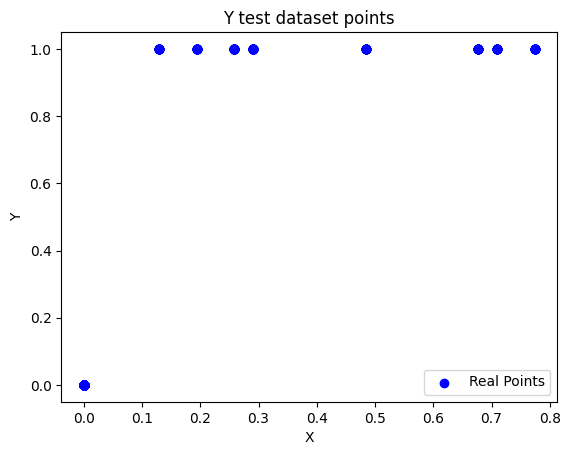

In [ ]:
plt.scatter(Y_test[:,0], Y_test[:,1], color='blue', label='Real Points')

# # Set the x-axis label to "X"
plt.xlabel('X')

# # Set the y-axis label to "Y"
plt.ylabel('Y')

# # Set the title of the plot to "Real vs Predicted Points"
plt.title('Y test dataset points')

# # Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

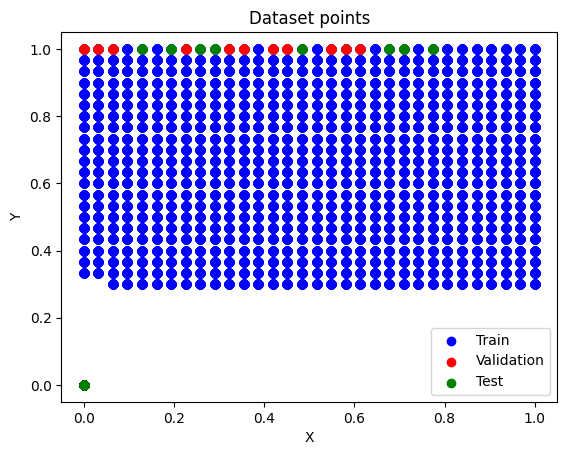

In [ ]:
plt.scatter(Y_train[:,0], Y_train[:,1], color='blue', label='Train')
plt.scatter(Y_val[:,0], Y_val[:,1], color='red', label='Validation')
plt.scatter(Y_test[:,0], Y_test[:,1], color='green', label='Test')

# # Set the x-axis label to "X"
plt.xlabel('X')

# # Set the y-axis label to "Y"
plt.ylabel('Y')

# # Set the title of the plot to "Real vs Predicted Points"
plt.title('Dataset points')

# # Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Machine Learning - Loss Functions for X and Y

def loss_function_xy(y_true, y_pred):
    xy_true = y_true[:, :2]
    xy_pred = y_pred[:, :2]
    y_true = xy_true[:, 1]
    x_true = xy_true[:, 0]
    y_pred = xy_pred[:, 1]
    x_pred = xy_pred[:, 0]
    distance = (K.sqrt(K.square(y_pred - y_true) + K.square(x_pred - x_true)))
    return distance

In [ ]:
# Machine Learning - Metric Functions for X and Y

def xy_metric (y_true, y_pred):
    xy_true = y_true[:, :2]
    xy_pred = y_pred[:, :2]
    y_true = xy_true[:, 1]
    x_true = xy_true[:, 0]
    y_pred = xy_pred[:, 1]
    x_pred = xy_pred[:, 0]
    distance = tf.reduce_mean(K.sqrt(K.square(y_pred - y_true) + K.square(x_pred - x_true)))
    return distance

In [ ]:
# Machine Learning - Loss Functions for theta

def loss_function_theta(y_true, y_pred):
    theta_true = y_true
    theta_pred = y_pred
    return tf.reduce_mean(tf.abs(theta_true - theta_pred))

In [ ]:
# Machine Learning - Metric Functions for theta

def theta_metric (y_true, y_pred):
    theta_true = y_true
    theta_pred = y_pred
    return tf.reduce_mean(tf.abs(theta_true - theta_pred))

In [ ]:

# Machine Learning - Scikit-optimizer

# search_space = [ 
#                 Categorical(['relu', 'tanh'], name='activation'), 
#                 Real(1e-5, 1e-2, name='learning_rate'), 
#                 Real(1e-5, 1e-2, name='alpha')]
                

# @use_named_args(search_space)
# def objective(activation, learning_rate, alpha):
#     model = MLPRegressor(hidden_layer_sizes=(range(1, 1029), range(1, 1029), range(1, 1029), range(1, 1029)), alpha = alpha , activation=activation, learning_rate_init = learning_rate, max_iter=5000, early_stopping=True, validation_fraction=0.2, n_iter_no_change=50, tol=0.0001, random_state=42)
#     # model.fit(X_train, Y_train)

#     scores = cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_error')
    
#     # Calculate the mean of the negative mean squared error
#     mean_mse = np.mean(-scores)
    

#     return mean_mse

# result = gp_minimize(objective, search_space, n_calls=100, random_state=42, verbose=10)

# print("Best parameters: hidden_layer_sizes = %d, activation = %s, learning_rate = %.6f" % (res.x[0], res.x[1], res.x[2]))

    




In [ ]:
# print("Best parameters: hidden_layer_sizes = %d, activation = %s, learning_rate = %.6f" % (result.x[0], result.x[1], result.x[2]))
# print("Best score = %.4f" % (result.fun))
# print("Best Loss = %.4f" % (result.fun))

print(data_sen_size_2)

400


In [ ]:
# Machine Learning - Build the model

inputs = tf.keras.Input(shape=(data_sen_size_2,))

x = tf.keras.layers.Dense(400, activation='sigmoid')(inputs)
x = tf.keras.layers.Dense(200, activation='sigmoid')(x)
x = tf.keras.layers.Dense(100, activation='sigmoid')(x)
x = tf.keras.layers.Dense(50, activation='sigmoid')(x)
x = tf.keras.layers.Dense(25, activation='sigmoid')(x)

xy_output = tf.keras.layers.Dense(2, activation='linear', name='xy')(x)
theta_output = tf.keras.layers.Dense(1, activation='linear', name='theta')(x)

model = tf.keras.Model(inputs=inputs, outputs=[xy_output, theta_output])

model.summary()

optimizer = Adam(learning_rate=0.0001)
# model.compile(loss = 'SparseCategori', optimizer = 'adam', metrics = ['accuracy'])
model.compile(optimizer = optimizer, loss = {'xy': loss_function_xy, 'theta': loss_function_theta}, loss_weights={'xy': 0.6, 'theta': 0.4}, metrics = {'xy': xy_metric, 'theta': theta_metric})

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 400)]        0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 400)          160400      ['input_3[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 200)          80200       ['dense_10[0][0]']               
                                                                                                  
 dense_12 (Dense)               (None, 100)          20100       ['dense_11[0][0]']               
                                                                                            

In [ ]:
# Machine Learning - Train the model
predict = model.fit(X_train, {"xy": Y_train[:, :2], "theta": Y_train[:, 2]}, validation_data=(X_val, {"xy": Y_val[:, :2], "theta": Y_val[:, 2]}), epochs=2500, batch_size=32, verbose = 1)

Epoch 1/2500
1736/1736 [==============================] - 6s 3ms/step - loss: 0.3563 - xy_loss: 0.3963 - theta_loss: 0.2963 - xy_xy_metric: 0.3963 - theta_theta_metric: 0.2963 - val_loss: 0.6932 - val_xy_loss: 0.8137 - val_theta_loss: 0.5124 - val_xy_xy_metric: 0.8137 - val_theta_theta_metric: 0.5124
Epoch 2/2500
1056/1736 [=================>............] - ETA: 1s - loss: 0.3033 - xy_loss: 0.3152 - theta_loss: 0.2854 - xy_xy_metric: 0.3152 - theta_theta_metric: 0.2854

KeyboardInterrupt: 

In [ ]:
# Machine Learning - Evaluate the model

losses = model.evaluate(X_test, {'xy': Y_test[:, :2], 'theta': Y_test[:, 2]}, batch_size=32)
print("Mean Squared Error: ", losses)

losses = model.evaluate(X_val, {'xy': Y_val[:, :2], 'theta': Y_val[:, 2]}, batch_size=32)
print("Mean Squared Error: ", losses)


7/7 [==============================] - 0s 2ms/step - loss: 0.0823 - xy_loss: 0.0552 - theta_loss: 0.1230 - xy_xy_metric: 0.0556 - theta_theta_metric: 0.1299
Mean Squared Error:  [0.08230695873498917, 0.05518049746751785, 0.12299665808677673, 0.055552151054143906, 0.1298503577709198]
13/13 [==============================] - 0s 2ms/step - loss: 0.0816 - xy_loss: 0.0550 - theta_loss: 0.1216 - xy_xy_metric: 0.0552 - theta_theta_metric: 0.1232
Mean Squared Error:  [0.08162509649991989, 0.054986704140901566, 0.12158268690109253, 0.05519453436136246, 0.12320142239332199]


In [ ]:
# create a learning curve for loss with a graph


7/7 [==============================] - 0s 1ms/step
Mean Error for test data (distance):  0.28098152480892824 meters
Mean squared error for test data (degrees):  0.3091206165165233 radians
#############################################################################################################
Mean Error for test data (distance):  tf.Tensor(0.3668160565892565, shape=(), dtype=float64) meters


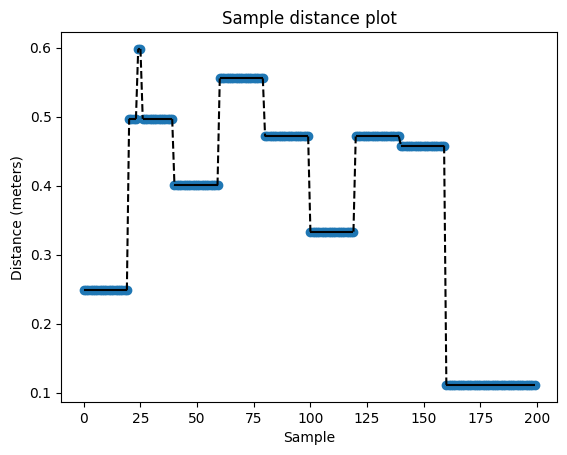

In [ ]:
# Machine Learning - Make predictions

y_pred, theta_pred = model.predict(X_test)

y_pred_x = y_pred[:, 0]
y_pred_y = y_pred[:, 1]
y_pred_theta = theta_pred

# Round the predicted values to the nearest integer
y_pred_x = np.rint(y_pred_x.flatten())
y_pred_y = np.rint(y_pred_y.flatten())
y_pred_theta = np.rint(y_pred_theta.flatten())

# Combine the predicted x and y values into a single array of (x, y) tuples
y_pred = np.stack((y_pred_x, y_pred_y), axis=1)

# Calculate accuracy score
mse = metrics.mean_squared_error(Y_test[:, :2], y_pred)

print("Mean Error for test data (distance): ", math.sqrt(mse), "meters" )

mse = metrics.mean_squared_error(Y_test[:, 2], y_pred_theta)
print("Mean squared error for test data (degrees): ", math.sqrt(mse), "radians" )

print("#############################################################################################################")

err = tf.reduce_mean(tf.sqrt(tf.square(Y_test[:, 0] - y_pred[:, 0]) + tf.square(Y_test[:, 1] - y_pred[:, 1])))
print("Mean Error for test data (distance): ", err, "meters")


distance = (tf.sqrt(tf.square(Y_test[:, 0] - y_pred[:, 0]) + tf.square(Y_test[:, 1] - y_pred[:, 1])))

fig, ax = plt.subplots()

ax.scatter(range(len(distance)), distance)

ax.set_xlabel('Sample')
ax.set_ylabel('Distance (meters)')
ax.set_title('Sample distance plot')


# Show lines between adjacent samples
for i in range(len(distance)-1):
    ax.plot([i, i+1], [distance[i], distance[i+1]], 'k--')

# Show the plot
plt.show()

7/7 [==============================] - 0s 2ms/step
0
0
1
2
2
4
3
6
4
8
5
10
6
12
7
14
8
16
9
18
10
20
11
22
12
24
13
26
14
28
15
30
16
32
17
34
18
36
19
38
20
40
21
42
22
44
23
46
24
48
25
50
26
52
27
54
28
56
29
58
30
60
31
62
32
64
33
66
34
68
35
70
36
72
37
74
38
76
39
78
40
80
41
82
42
84
43
86
44
88
45
90
46
92
47
94
48
96
49
98
50
100
51
102
52
104
53
106
54
108
55
110
56
112
57
114
58
116
59
118
60
120
61
122
62
124
63
126
64
128
65
130
66
132
67
134
68
136
69
138
70
140
71
142
72
144
73
146
74
148
75
150
76
152
77
154
78
156
79
158
80
160
81
162
82
164
83
166
84
168
85
170
86
172
87
174
88
176
89
178
90
180
91
182
92
184
93
186
94
188
95
190
96
192
97
194
98
196
99
198


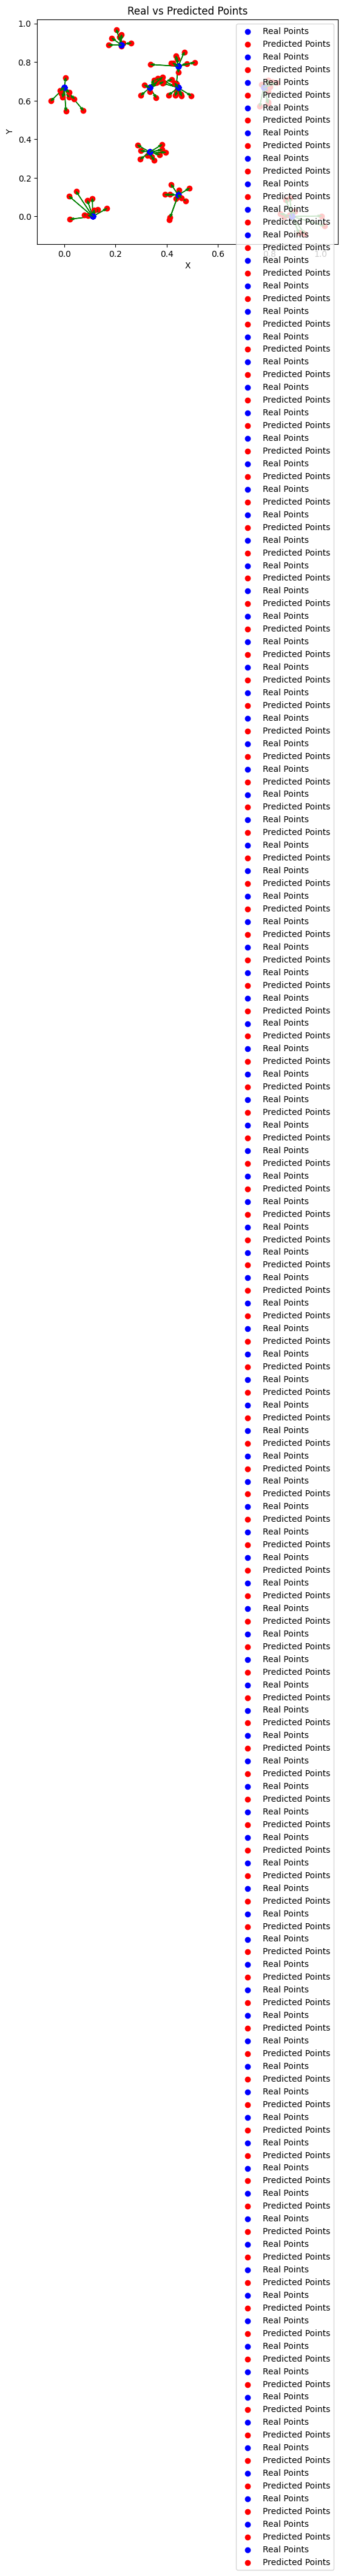

In [ ]:

# Assume you have a trained model called "model"
# and a test set called X_test and y_test

# Make predictions on the test set
y_pred, theta_pred = model.predict(X_test)

# Create a scatter plot showing the real points in blue
# plt.scatter(Y_test[:,0], Y_test[:,1], color='blue', label='Real Points')

x_pred = y_pred[:, 0]
y_pred = y_pred[:, 1]

# Create a scatter plot showing the predicted points in red
# plt.scatter(x_pred, y_pred, color='red', label='Predicted Points')

# Loop through each point in the test set
for i in range(0 , 100):
    print(i)
    k = i * 2
    print(k)
    # Get the x and y coordinates for the real and predicted points
    x_real, y_real, theta_real = Y_test[k]
    x_pred_arrow = x_pred[k]
    y_pred_arrow = y_pred[k]
    plt.scatter(x_real, y_real, color='blue')
    plt.scatter(x_pred_arrow, y_pred_arrow, color='red')
    # Add an arrow from the real point to the predicted point
    plt.arrow(x_real, y_real, x_pred_arrow - x_real, y_pred_arrow - y_real, 
              length_includes_head=True, head_width=0.01, color='green')
    
# Set the x-axis label to "X"
plt.xlabel('X')

# Set the y-axis label to "Y"
plt.ylabel('Y')

# Set the title of the plot to "Real vs Predicted Points"
plt.title('Real vs Predicted Points')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

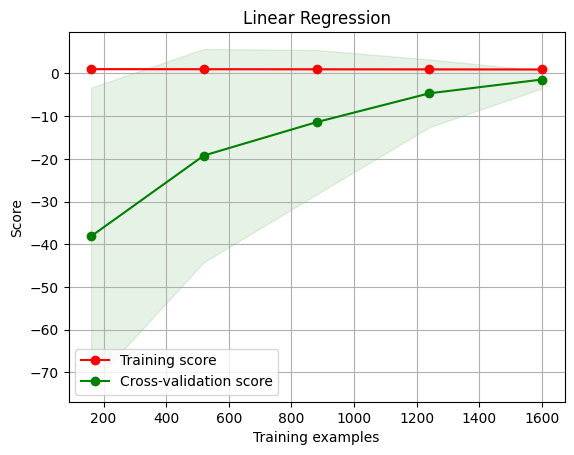

Break Point


<Figure size 640x480 with 0 Axes>

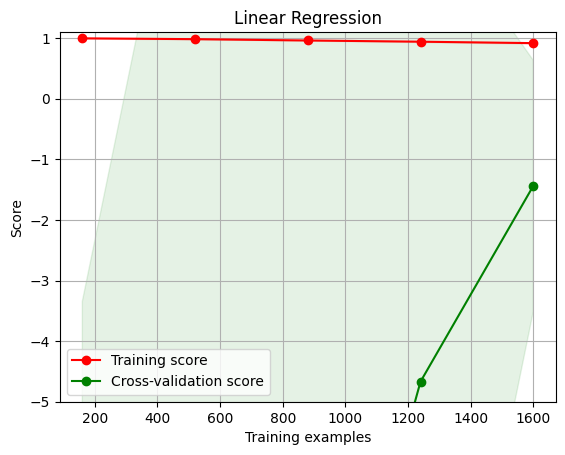

In [ ]:
from sklearn.linear_model import LinearRegression

# Create a LinearRegression object
lr = LinearRegression()

# Plot the learning curve
plot_learning_curve(lr, "Linear Regression", X, Y, cv=5)
plt.show()

plt.savefig('plot.png')
print('Break Point')


plot_learning_curve(lr, "Linear Regression", X, Y, cv=5)
plt.ylim(-5, 1.1)
plt.show() 